# Reconstruct MRI Images

#### Author： Haodong Zuo，Jing Bai， Shuqi Liu,  Yifan Guo and Yunong Jiang

results : https://drive.google.com/drive/folders/1p6502DZXtXj_dWWR1b2UHcBijeOrGMG2?usp=sharing

## 1 Introduction

>FastMRI is a cooperation project between Facebook AI Research and NYU Langone Health.[1]  

They have released a standardized set of AI tools, baselines and opened MRI data set. Baseline models mainly for ML-based image reconstruction from k-space data subsampled at 4 times and 8 times scan accelerations. 

>The initial data set release includes approximately 1.5 million MRI images drawn from 10,000 scans, as well as raw measurement data from nearly 1,600 scans.[2]

Standardized data will help address the challenge of consistency which also considered as the first large-scale MRI data set, so we choose a partial subset from the total fast MRI data set which contains raw k-space data from 100 three-dimensional volumes, each having about 30-40 two-dimensional slices. We split the data into 70 percentages for training and 30 percentages for testing. For the training set, each volume contains only fully sampled k-space data. 

>For the test set, each data contains a 4-fold undersampled k-space data and a 4-fold mask that generates the undersampled k-space.[3] 

The 8-fold undersampled k-space data and the 8-fold mask were also included. We hope that to use provided AI-driven image reconstruction baseline to achieve more advanced deep learning methods and more accurate results than previous works.

## 2 Design

### 2.1 Model

Computer vision is intended to recognize and understand the content in an image/video by using various deep learning techniques. There are many excellent algorithms for semantic segmentation of medical images, including MRI image processing. 

>For example, Olaf Ronneberger, Phillip Fischer, and Thomas Brox first established a more elegant framework based on CNN in 2015, U-Net.[5] 

Owing to its models on fully connected convolutional layers has been modified to enable the Data, biomedical images can be better segmented,

The entire original U-Net network structure is similar to a large U letter: input one $1\times320\times320$ image into contraction path(same as traditional convolutional network) which consists of a non-filled convolution with a $3\times3$ convolution kernel, after each convolution, it functions through a ReLu activation function, and a $2\times2$ maximum pool and a $2$ step size. Each step in the contraction path first uses up-convolution. Each time it is used, the number of feature channels is halved and the size of the feature map is doubled. The expansion path consists of $2\times2$ upper convolution, the output channels of the upper convolution are half of the original, and then are connected in series with the corresponding feature map (after cropping) (to obtain channels of the same size as the original), and then pass through two dimensions of $3\times3$'s convolution and ReLu effect. The size of the convolution kernel of the last layer is $1\times1$, and the feature map of $64$ channels is converted into the result of a specific depth (the number of classifications, the second classification is $2$).In total, there are $23$ convolutional layers in this network and the size of the output image is equal to the size of the original image.

We use the U-Net structure drawing drawn by Latex to better explain the U-Net network we use.

In [7]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "U-Net.jpeg")

### 2.2 Loss Function

In machine/deep learning, the loss function is the method that calculates the error and evaluates the matching performance between a specific algorithm model and given data. The large value of the loss function indicates that prediction deviates greatly from the real results. And with some optimizing measure, loss function learns to decrease the loss of the predicted data gradually. There are some different loss functions applied to various models. In general, loss functions could be divided into two basic categories according to the type of the learning task we do--Regression losses and Classification losses. To exemplify, MSE loss, L1 loss and MBE loss are regression losses, while SVM loss and cross-entropy loss are classification losses.

In the MRI experiment, to reconstruct images with good quality, we designed a reasonable model with some loss functions and minimized the loss by comparing several loss functions and optimization functions. There are three loss functions we take to optimize the results.

#### 2.2.1  L1 loss

The L1 loss function is calculated by the least absolute deviations. The equation is:

$$ L_1(v_t, v_0) = \frac{1}{n} \sum_{i=1}^n \left| v_t - v_0 \right| , \tag{1} $$

where $ v_t $ is the output and $ v_0 $ is the corresponding ground truth.

L1 loss is common and suitable to start the experiments. It is an essential method for lots of optimization of the results. However, Mathematically, the L1 loss is calculated as the absolute value, but it cannot show the big difference between elements. For example, some elements are negative, some elements are positive, but the sum is close to 0.

However, in the reverse transfer, no matter how small the Loss of L1 is calculated, the error return is always a fixed value, which leads to the possibility that when the system is approaching optimization, the error return makes the whole system run out of balance. But this kind of setting also has an advantage that a stable error return can ensure the change of the whole system in a certain range, it is easier to catch the bug. To exemplify, if the system is not balanced, it is probably a weight problem.

#### 2.2.2 L2(MSE) loss

The L2(MSE) loss function is defined as the least square errors. The formula is:

$$ L_{MSE}(v_t, v_0) = \frac{1}{n} \sum_{i=1}^n (v_t - v_0)^2 , \tag{2} $$

where $ v_t $ is the output and $ v_0 $ is the corresponding ground truth.

>MSE loss is the smallest in the experiment due to its result is positive. In reverse transfer, the error return of L2 is proportional to the output and the same as the relationship about the difference between the corresponding element in the template. In this case, the error return of L2 is positive, negative or zero. In this case, if the difference between the output of an element and a template is large, the error return of that part becomes very large easily[9].

#### 2.2.3 SSIM loss

>The SSIM loss function (the structural similarity Index) is a perceptual metric. It is used to calculate image quality degraded loss caused by dealing with data compression or data transmission. It could also say that it computes a similar index between two images by evaluating the structural difference among nearby pixels. It always carries out requiring two images from the same image capture and sometimes is calculated depended on three-dimensional volumes rather than two-dimensional volumes. The equation is shown as[10]:

$$ L_{SSIM}(v_t, v_0) = \frac{(2\mu_{v_t}\mu_{v_0}+C_1)(2\sigma_{v_t,v_0}+C_2)}{(\mu_{v_t}^2+\mu_{v_0}^2+C_1)(\sigma_{v_t}^2+\sigma_{v_0}^2)+C_2)} , \tag{3} $$ 

where $ \mu_{v_0}, \mu_{v_t}, \sigma_{v_0},\sigma_{v_t} \ and \ \sigma_{v_t,v_0} $ are the local means, standard deviations, and cross-covariance for images $ v_t, v_0 $.

The loss could be calculated by using SSIM. The higher the index calculated, the lower the loss would be got. Sometimes, SSIM loss has the advantage to reduce the loss.

### 2.3 Optimizer

>The optimization algorithm is the main approach which is used in the machine learning model and deep learning model to minimize their error rate nowadays.[4] 

Even with the same dataset, model and loss function, diverse optimizers are likely to lead to different results. Therefore, the choice of the optimizer would be quite significant.

>According to Ruder, gradient descent is one of the most widely used in optimization algorithms to optimize neural networks. [5]

To make up for the disadvantages of vanilla gradient descent, researchers have invented a series of variant algorithms that gradually evolved from the original SGD (stochastic gradient descent) to N-Adam. In this experiment, Adam and SGD optimizer will be applied. They both are the variants of gradient descent algorithm.

#### 2.3.1 Gradient Descent

>Gradient descent means that given the model parameter $θ∈R^d$ and objective function $J(θ)$ to be optimized, the algorithm minimizes $J(θ)$ by updating $θ$ in the opposite direction of the gradient $∇_θ J(θ)$. The learning rate $η$ determines the update step size at each moment. For each moment $t$, the following steps could be used to describe the gradient descent process:[5]

Calculate the gradient of the objective function concerning parameters

<center>$g_t=∇_θ J(θ) \tag{4}$</center>

Calculate first-order and second-order momentum from historical gradients

<center>$m_t=∅(g_1,g_2,…g_t ) \tag{5}$</center>
<center>$v_t=ψ(g_1,g_2,⋯g_t ) \tag{6}$</center>

Update model parameters

<center>$θ_(t+1)=θ_t-1/√(v_t+ϵ) m_t ,\tag{7}$<center> 

where $ϵ$ is a smoothing term to prevent the denominator from being zero, usually $1e-8$.

#### 2.3.2 SGD (stochastic gradient descent)

Instead of performing computations on the whole dataset — which is redundant and inefficient — SGD only computes on a small subset of a random selection of data examples.


>It does away the redundancy by performing one update at a time. Thus, SGD would be much faster than gradient descent and it is also applied online.[5] 

>However, "SGD produces the same performance as regular gradient descent when the learning rate is low.(2019)"[4] Besides, the objective function will fluctuate intensely when SGD updates with a high variance. On the other hand, as a result of continuous overshoot, it may lead to very complicated convergence at the end until it is minimally accurate.[5]

Most importantly, compared to other optimizers, SGD is relatively simple, because it does not use the concept of momentum. 

>According to Ruder, "SGD has trouble navigating ravines, such that areas where the surface curves much more steeply in one dimension than in another, which are common around local optima. In these scenarios, SGD oscillates across the slopes of the ravine while only making hesitant progress along the bottom towards the local optimum."[5]

>To avoid this condition, researchers introduce the concept of momentum $γ$ which helps accelerate SGD descent in the right direction and suppress fluctuation. The momentum term $γ$ is usually set to 0.9 or a similar value(2016).[5]

Thus, the computation process would be simple when it does not use the concept of momentum.

$$m_t=ηg_t  ,v_t=I^2  ,ϵ=0 \tag{8}$$ 

At this point, the update step is the easiest:

<center>$θ_(i+1)=θ_t-ηg_t \tag{9}$</center>

>The shortcoming of SGD is that it converges slowly and may oscillate at the saddle point. Moreover, how to choose the learning rate reasonably is a major difficulty for SGD.[5]

Then, the momentum will be added:

<center>$m_t=γm_(t-1)+ηg_t \tag{10}$</center>

>This formula adds the $γm_(t-1)$ related to the step size at the previous step, which means that the parameter update direction is not only determined by the current gradient but also related to the previously accumulated descent direction. Finally, the convergence will become faster and oscillation will be reduced.[5]

####  2.3.3 Adam (Adaptive Moment Estimation)

>"Adam is another method that computes adaptive learning rates for each parameter (2016),"[5] 

as an algorithm for first-order gradient-based optimization of stochastic objective functions which is also based on adaptive estimates of lower-order moments. It can be considered as a combination of RMS-prop and SGD with momentum.

>It cannot only save an exponentially decaying average of past squared gradients like RMS-prop but also keeps an exponentially decaying average of past gradient set, which is similar to momentum. Adam calculates the first-order momentum with an exponential moving average.[6]

More formally,

<center>$m_t=η[β_1 m_(t-1)+(1-β_1 ) g_t ] \tag{11}$</center>
<center>$v_t=β_2 v_(t-1)+(1-β_2 )*diag(g_t^2 ) \tag{12}$</center>

where $m_0=0$, $v_0=0$, $β_1=0.9$ and $β_2=0.999$.

>At this point, $m_t$ and $v_t$ mean the estimates of the first moment (the mean) and the second moment (the uncentered variance) of the gradients respectively, so they are the names of the method.[7] 

Notice that in the initial phase of the iteration, $m_t$ and $v_t$ have a shift from the initial value (too much bias to 0). Therefore, bias corrections can be made for first and second-order momentum.

>According to Ruder, they counteract these biases by computing bias-corrected first and second-moment estimates.[5]

<center>$m ̂_t=m_t/(1-β_1^t ) \tag{13}$</center> 
<center>$v ̂_t=v_t/(1-β_2^t ) \tag{14}$</center>

<center>$m ̂_t=m_t/(1-β_1^t ) \tag{13}$</center> 

<center>$v ̂_t=v_t/(1-β_2^t ) \tag{14}$</center>

Use the contents above to update parameters which produce the Adam rule:


<center>$θ_(t+1)=θ_t-1/(√(v ̂_t )+ϵ) m ̂_t \tag{15}$</center>

which can ensure that the iteration is relatively stable.


## 3 Implementation

Magnetic resonance imaging(MRI) is a powerful tool applied to the medical area, and It is known that the data acquired from an MRI scanner is a complex-valued k-space data, where k-space behalves the spatial frequency information (Fourier coefficients) of an object imaged. Some measures could be taken to reconstructed images, such as the inverse discrete Fourier transform(DFT) to the k-space data. However, it takes relatively more time and costs to form fully sampled images. To get clear and accurate images in fast velocity, we are decided to take an undersampling method to reconstruct images.

The cartesian undersampling trajectory is a good method. First, two random mask functions generated by trajectory. They are a 4-fold acceleration mask and an 8-fold acceleration mask. Then, masked k-space data could be got by multiplying a 4-fold acceleration mask and an 8-fold acceleration mask with k-space data respectively. Finally, undersampled images could be reformed applying the inverse DFT to k-space data.

In the experiment, firstly, we loaded the MRI data set and construct the model using U-net based on Fully Convolutional Networks. Then we set some basic conditions, for example, epochs are 30, the learning rate is 0.0001  which lays the foundation for later comparison. Most important of all, we chose three loss functions and two optimized methods running with channel 1 separately to view the best result. Here are some running processes.

In the beginning, we selected MSE as the loss function and Adam as the optimizer with channel 1 respectively to run procedures. We found the result of channel 1. Then we tested SGD as the optimizer and keeping the original loss function with channel 1. The results indicated that Adam was better than SGD as the optimizer. Therefore, we kept Adam as the optimizer with channel 1 and compared three loss functions, which are L1 loss function, MSE loss function, and SSIM as the loss function. The computational consequences demonstrate that the SSIM performed the best among three loss functions.

In [2]:
%matplotlib inline

import h5py, os
import numpy as np
from matplotlib import pyplot as plt
from functions import transforms as T
import torch
from functions.subsample import MaskFunc
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

### 3.1 Data_loader

The MRI dataset we used is a set of HDF5 files that can be read with the h5py package. Each file corresponds to one MRI scan volume, containing the corresponding k-space data and some metadata related to the scan. In MRI raw data, k-space is complex-valued and has the following shape: (number of slices, height, width). MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [3]:
def show_slices(data, slice_nums, cmap=None): # visualisation
    #fig = plt.figure(figsize=(15,10))
    fig, axes = plt.subplots(nrows=1, ncols=4)
    for i, num in enumerate(slice_nums):
        #plt.subplots(len(slice_nums), 1,  i + 1, nrows=1, ncols=4)
        axes[i].imshow(data[num], cmap=cmap)
        plt.axis('off')
    plt.show()

At first, we import the data set and initialize the parameters.

In [ ]:
class MRIDataset(DataLoader):  # import MRIdata set 
    # initialize some parameters
    def __init__(self, data_list, acceleration, center_fraction, use_seed): 
        self.data_list = data_list
        self.acceleration = acceleration  
        self.center_fraction = center_fraction
        self.use_seed = use_seed

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]
        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed)

Next, we define the parameters in every epoch in batch_size. k-space should be converted into image space using PyTorch. The to_tensor function can convert Numpy arrays to PyTorch Tensors. Then, we can simulate under-sampled data by creating a mask and applying it to k-space.We created a mask function object and defined a mask with acceleration rate. About Images, we use inverse discrete function transform to get complex image firstly. Then, we crop the images to the complex central 320x320 pixel region, following evaluation will be made based on those images. After that, we normalize the images with 10^-6 regularization weight.We not only compute the absolute value of ground truth and under-sampled images to get real images, but also train model using the under-sampled image then generate output images. The printed images from left to right are under-sampled image, output image and ground truth. The structural similarity is calculated between ground truth and under-sampled images.

In [ ]:
def get_epoch_batch(subject_id, acc, center_fract, use_seed=True): # define the parameters in every epoch in batch_size
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name, slice = subject_id  
    # h5py.file only can be read
    with h5py.File(rawdata_name, 'r') as data:      
        rawdata = data['kspace'][slice]
    # convert from numpy array to pytorch tensor
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape

    # apply random mask
    shape = np.array(slice_kspace.shape)
    # create the mask function object
    mask_func = MaskFunc(center_fractions=[center_fract], accelerations=[acc])
    seed = None if not use_seed else tuple(map(ord, fname))
    # use seed to exclude randomness
    mask = mask_func(shape, seed)   
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)  # masked kspace data with AF=4
    masks = mask.repeat(S, Ny, 1, ps)                                        # masks when AF=4
    
    # inverse discrete function transform to get the complex image
    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)
    # crop the images to the complex central 320x320 pixel region, as evaluation will be made based on those images
    img_gt=T.complex_center_crop(img_gt,[320,320])
    img_und=T.complex_center_crop(img_und,[320,320])
    
    
    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: norm = 1e-6
    
    # normalized data
    img_gt, img_und, rawdata_und = img_gt/norm, img_und/norm, masked_kspace/norm
        
    return img_gt, img_und, norm

We divided dataset into two parts, 70% of dataset used in training and the rest part used in validating. Next, we go through each subset and list all the file names, the file paths and the slices of subjects in the training and validation sets. Besides, we find that the first five slices are mostly noise, so we exclude them.

In [ ]:
def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      

    data_list['train'] = []
    data_list['kspace_4af'] = []
    data_list['kspace_8af'] = []

    for fname in sorted(os.listdir(train_data_path)):
            
            subject_data_path = os.path.join(train_data_path, fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]
            data_list['train'] += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]
            
    for fname in sorted(os.listdir(val_data_path)):
            
            subject_data_path = os.path.join(val_data_path, fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace_4af'].shape[0]
            data_list['kspace_4af'] += [(fname, subject_data_path, slice) for slice in range(0, num_slice)]
            
    for fname in sorted(os.listdir(val_data_path)):
            
            subject_data_path = os.path.join(val_data_path, fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace_8af'].shape[0]
            data_list['kspace_8af'] += [(fname, subject_data_path, slice) for slice in range(0, num_slice)]

    
    return data_list    

### 3.2 Model


The basic convolution block is encapsulated, which consists of the CNN-based basic structure as CNN: (convolution, activation, normalization) and put them into separate nn.Module.

Among them, the linear unit ReLU(nn.ReLU()) is modified as a non-linear activation function, and the dropout(nn.Dropout2d(drop_prob)) theory is used to selectively ignore neurons during the training phase to avoid overfitting the model.

In [ ]:
class ConvBlock(nn.Module):
    """
    A Convolutional Block that consists of two convolution layers each followed by
    instance normalization, relu activation and dropout.
    """
    # (conv->BN->ReLu)*2
    # conv -> convolution
    # BN -> batch normalization
    # ReLu -> rectified linear unit
    def __init__(self, in_chans, out_chans, drop_prob): # defines the components that make up the model
        """
        Args:
            in_chans (int): Number of channels in the input.
            out_chans (int): Number of channels in the output.
            drop_prob (float): Dropout probability.
        """
        super().__init__()          # U-Net model input, output channels and dropout probability

        self.in_chans = in_chans    # number of channels in the input.
        self.out_chans = out_chans  # number of channels in the output.
        self.drop_prob = drop_prob  # dropout probability.
        
        # sequential container for buliding neural network quickly
        self.layers = nn.Sequential(
            # initial convolution settings: Inital input and output channels, kernel size is 3, padding is 1
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1),
            #nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob),
            nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1),
            #nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob)
        )
        
    # call the forward model to perform a forward pass and output predictions.
    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        return self.layers(input)

    def __repr__(self):
        return f'ConvBlock(in_chans={self.in_chans}, out_chans={self.out_chans}, ' \
            f'drop_prob={self.drop_prob})'

The changes in each step are shown in the comments in the code below

In [ ]:
class UnetModel(nn.Module):
    """
    PyTorch implementation of a U-Net model.
    This is based on:
        Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-net: Convolutional networks
        for biomedical image segmentation. In International Conference on Medical image
        computing and computer-assisted intervention, pages 234–241. Springer, 2015.
    """

    def __init__(self, in_chans, out_chans, chans, num_pool_layers, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input to the U-Net model.
            out_chans (int): Number of channels in the output to the U-Net model.
            chans (int): Number of output channels of the first convolution layer.
            num_pool_layers (int): Number of down-sampling and up-sampling layers.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob
        # define the down-sampling operation
        self.down_sample_layers = nn.ModuleList([ConvBlock(in_chans, chans, drop_prob)])
        ch = chans
        for i in range(num_pool_layers - 1):
            self.down_sample_layers += [ConvBlock(ch, ch * 2, drop_prob)]
            ch *= 2
            # after each down-sampling, the number of channels will be doubled, the size will become half
        self.conv = ConvBlock(ch, ch, drop_prob)
        # define the up-sampling operation
        self.up_sample_layers = nn.ModuleList()
        for i in range(num_pool_layers - 1):
            self.up_sample_layers += [ConvBlock(ch * 2, ch // 2, drop_prob)]
            ch //= 2   # take integer division
            
        # after each up-sampling, the number of channels will be half, the size will become doubled
        self.up_sample_layers += [ConvBlock(ch * 2, ch, drop_prob)]  
        # because it is a splicing operation, it needs to be twice the input channel.
        self.conv2 = nn.Sequential(   
            # a sequential container. Modules will be added to it in the order they are passed in the constructor. Alternatively, an ordered dict of modules can also be passed in.
            nn.Conv2d(ch, ch // 2, kernel_size=1),
            nn.Conv2d(ch // 2, out_chans, kernel_size=1),
            nn.Conv2d(out_chans, out_chans, kernel_size=1),
        )
        # the convolution kernel becomes 1, out_chans becomes 2,because medical images are binary
            
    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        stack = []
        output = input
        # Apply down-sampling layers
        # define the down-sampling convolutional layer (corresponding to one red arrow and two blue arrows in the figure)
        for layer in self.down_sample_layers:
            output = layer(output)
            # appends a given module to the end of the list.
            stack.append(output)  
            # applies a 2D max pooling over an input signal composed of several input planes
            output = F.max_pool2d(output, kernel_size=2)
            
        output = self.conv(output)

        # Apply up-sampling layers
        # define the upsampled convolutional layer and the fusion part (corresponding to a green arrow and two blue arrows in the figure)
        for layer in self.up_sample_layers:
            output = F.interpolate(output, scale_factor=2, mode='bilinear', align_corners=False) 
            # use bilinear interpolation，Each step of downsampling restores twice the original image
            output = torch.cat([output, stack.pop()], dim=1) 
            # use cat for Concatenates,dim=1 representing rows in a two-dimensional matrix
            output = layer(output)
        return self.conv2(output)


### 3.3 Function

#### 3.3.1 Evaluation Metric - SSIM

The structural similarity (SSIM) index measures the similarity between ground truth and under-sampled images by using the inter-dependencies among nearby pixels.  

>SSIM is inherently able to evaluate the structural properties of the objects in an image and is computed at diﬀerent image locations by using a sliding window.[2]

Besides, the SSIM used in our project is based on three-dimensional volumes. The number of SSIM values depends on how many volumes in the dataset.

In [ ]:
from skimage.measure import compare_ssim 
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
        )

#### 3.3.2 Save and load model 

Save the model in the specific directory with torch.save

In [ ]:
import shutil
def save_model(exp_dir, epoch, model, best_dev_loss, is_new_best):
    torch.save(
        {
            'epoch': epoch,
            'model': model.state_dict(),
            'best_dev_loss': best_dev_loss,
            'exp_dir': exp_dir
        },
        f=exp_dir + '/model.pt'
    )
    if is_new_best:
        shutil.copyfile(exp_dir + '/model.pt', exp_dir + '/best_model.pt')

load the model in the specfic directory with torch.load

In [ ]:
def load_model(checkpoint_file, device):
    checkpoint = torch.load(checkpoint_file)
    model = UnetModel(1, 1, 64, 5, 0).to(device)
    model.load_state_dict(checkpoint['model'])
    return model

#### 3.3.3 Train

First, read the figure from the training dataset and transform it to the resonable torch.size which is suitable to put in the model. Second, define the loss function and optimizer. Third, caculate the gradient, update the parameters  and put the loss in a list. Last, caculate the ssim value and append it in a ssims list.  

In [ ]:
def train_epoch(epoches, model, train_loader, optimizer):
        losses = list()
        ssims= list()
        model.train()
        for iteration, sample in enumerate(train_loader):
            img_gt, img_und, norm = sample


            img_und = img_und.squeeze(0).to(device).permute(0,3,2,1)
            img_gt = img_gt.squeeze(0).permute(0,3,2,1).to(device)


            target = T.complex_abs(img_gt.squeeze(0).permute(1,2,0)).unsqueeze(0).unsqueeze(0)
            img_und = T.complex_abs(img_und.squeeze(0).permute(1,2,0))
            img_und = img_und.unsqueeze(0).unsqueeze(0)                   #channel 1
            output = model(img_und)

    #LOSS
    
#             loss = F.l1_loss(output, target)  # L1 loss function

#             loss_function = nn.MSELoss()      # MSE loss function
#             loss = loss_function(output,target)

            ssim_loss = pytorch_ssim.SSIM()
            ssim_out = -ssim_loss(output,target)
            ssim_value = - ssim_out.data.item()

            optimizer.zero_grad()
#             loss.backward()     # implementing optimization using L1 or MSE loss 
            ssim_out.backward()
            optimizer.step()
        
#             losses.append(loss.item())  # add L1 or MSE loss
            losses.append(ssim_value)

            target = target.squeeze(0)
            output = output.squeeze(0)
            img_und = img_und.squeeze(0)

            ssims.append(ssim(target.cpu().detach().numpy(),output.cpu().detach().numpy()))


        print("train",epoch)
        print("trainloss",np.mean(losses))
        print("trainssim",np.mean(ssims))

#### 3.3.4 Evaluate

Use the validation dataset to evaluate the model. The process is almost the same as the train_epoch but it does not contain optimizer in order to validate the model by calculating the ssim value with the validation dataset.

In [ ]:
def evaluate(epoch, model, test_loader):
        losses = list()
        ssims= list()
        model.eval()
        for iteration, sample in enumerate(test_loader):
            img_gt, img_und, norm = sample


            img_und = img_und.squeeze(0).to(device).permute(0,3,2,1)
            img_gt = img_gt.squeeze(0).permute(0,3,2,1).to(device)


            target = T.complex_abs(img_gt.squeeze(0).permute(1,2,0)).unsqueeze(0).unsqueeze(0)
            img_und = T.complex_abs(img_und.squeeze(0).permute(1,2,0))
            img_und = img_und.unsqueeze(0).unsqueeze(0)                   #channel 1
            output = model(img_und)

    #LOSS
    
#             loss = F.l1_loss(output, target)  # L1 loss function

#             loss_function = nn.MSELoss()      # MSE loss function
#             loss = loss_function(output,target)
        
            ssim_loss = pytorch_ssim.SSIM()
            ssim_out = -ssim_loss(output,target)
            ssim_value = - ssim_out.data.item()

#             optimizer.zero_grad()
#             ssim_out.backward()
#             optimizer.step()

#             losses.append(loss.item())
            losses.append(ssim_value)

            target = target.squeeze(0)
            output = output.squeeze(0)
            img_und = img_und.squeeze(0)

            ssims.append(ssim(target.cpu().detach().numpy(),output.cpu().detach().numpy()))

            if iteration==2000:

                B = img_und.squeeze().cpu().detach()
                C = output.squeeze().cpu().detach() #channel 1
                D = target.squeeze().cpu().detach()
                all_imgs = torch.stack([B,C,D], dim=0)
                show_slices(all_imgs, [0, 1, 2], cmap='gray')
                print(ssim(target.cpu().detach().numpy(),output.cpu().detach().numpy()))
                plt.pause(1)
            
        print("test",epoch)
        print("testloss",np.mean(losses))
        print("testssim",np.mean(ssims))
        return np.mean(ssims)

### 3.4 Total Process

Firstly, we get the dataset from the specified path. Then, some parameters have been set as the best values. If conditions permit, GPU is the best choice which is much faster. The dataset would be divided into two groups: the first 1900 are set as train_dataset and the remaining are set as test_dataset. After choosing the right model, optimizer, and the learning rate, the data will be processed in 30 epochs. Select the best model to save in a specific directory.

In [ ]:
import pytorch_ssim
if __name__ == '__main__':
    
    data_path_train = '/data/local/NC2019MRI/train'
    data_path_val = '/data/local/NC2019MRI/train'
    exp_dir = '../model'
    if not (os.path.exists(exp_dir)): os.makedirs(exp_dir)
    checkpoint_file = '../model/best_model.pt'
    data_list = load_data_path(data_path_train, data_path_val) 
    
    # define parameters
    acc = 8     #  times acceleration
    cen_fract = 0.04 # center fraction 
    seed = False # random masks for each slice 
    num_workers = 12 # data loading is faster using a bigger number for num_workers. zero means using one cpu to load data
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu' 

    #divide the training dataset to train_dataset and validation dataset.The name 'test_dataset'is not proper in the function
    train_dataset = MRIDataset(data_list['train'][:1900], acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    test_dataset = MRIDataset(data_list['train'][1900:], acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=num_workers) 
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=num_workers)
    
    print(device)
    lr = 0.0001     # learning rate
    epoches = 30    # how many output times
    newModel=UnetModel(1,1,64,5,0).to(device) # channel 1
#     newModel=UnetModel(2,2,64,4,0).to(device)   # channel 2

#OPTIMIZER    

    optimizer = optim.Adam(newModel.parameters(),lr=lr)    #Adam optimizer
    #optimizer = optim.Adam(newModel.parameters(),lr=lr)   #SGD optimizer
    temp_ssims = 0
    for epoch in range(epoches):
        train_epoch(epoch, newModel, train_loader, optimizer)
        test_ssims = evaluate(epoch, newModel, test_loader)
        if test_ssims >= temp_ssims:                    #compare the output of the validation dataset in each epoch
            temp_ssims = test_ssims                     # save the model with the best ssim result
            save_model(exp_dir, epoch, newModel, temp_ssims , True)         
            
    eval_model = load_model(checkpoint_file, device)    # check the load model function

    eval_ssims = evaluate(0, eval_model, test_loader)
    print(eval_ssims)

### 3.5 Reconstruct test dataset

Build new class and functions to read the figure from the test dataset which does not conclude the ground truth. Then read the silces from the files and reconstruct them with the selected model. After that, we torch.cat them together to save in the file with the same name and different directory.

In [ ]:
class MRIDataset_test(DataLoader):
    def __init__(self, data_list, acceleration):
        # initialize some parameters
        self.data_list = data_list
        self.acceleration = acceleration 

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]
        return get_epoch_batch_test(subject_id)

In [ ]:
def get_epoch_batch_test(subject_id):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name, slice = subject_id  
    
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace_4af'][slice]
                      
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)# Convert from numpy array to pytorch tensor


    img_4af = T.ifft2(slice_kspace)# Apply Inverse Fourier Transform to get the complex image
    
    img_4af=T.complex_center_crop(img_4af,[320,320])#Central crop to [320,320]
    
    norm = T.complex_abs(img_4af).max()
    if norm < 1e-6: norm = 1e-6
    
    # normalized data
    img_4af = img_4af/norm

        
    return img_4af, fname

As for the test dataset, each file contains several figures. This function spilts the file to read the each figure and put it in the model chosen by the results. Then, stick the figures again to store the results in the h5 file with the same name but in different directory.

In [ ]:
def construction_test(model, test_loader):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu' 
    model.eval()
    Fname = ""
    recons = {}
    tmp = torch.rand(1,320,320)# a temp
    with torch.no_grad():
        for iteration, sample in enumerate(test_loader):
            img_und, fname = sample
            fname = fname[0]
            img_und = img_und.squeeze(0).to(device).permute(0,3,2,1) # transform the img from the test dataset 
            img_und = T.complex_abs(img_und.squeeze(0).permute(1,2,0))
            img_und = img_und.unsqueeze(0).unsqueeze(0)  
            out = model(img_und)                                    #same as the train_epoch, the figure put in the model should be torch.Size([1, 320, 320])
            out = out.cpu().squeeze(1)
            if (fname!= Fname):                                     #read slices one by one in the same file 
                                                                    
                if(iteration != 0):
                    recons[Fname] = tmp.numpy()
                    #print(recons[Fname].shape)
                Fname = fname
                tmp = out
                #print(tmp.shape)
            else:                                                    #stick the slice together in a file (35,320,320) 
                tmp = torch.cat((tmp,out),0)                         #when the name of the file changes, stop torch.cat
                #print(tmp.shape)
    recons[Fname] = tmp.numpy()
    return recons   

Creat new keys 'recon_4af' and recon_8af' in the file to store the reconstructed figure

In [ ]:
def save_reconstructions(recon_4af,recon_8af, out_dir):
    """
    Saves the reconstructions from a model into h5 files that is appropriate for submission
    to the leaderboard.
    Args:
        reconstructions (dict[str, np.array]): A dictionary mapping input filenames to
            corresponding reconstructions (of shape num_slices x height x width).
        out_dir (pathlib.Path): Path to the output directory where the reconstructions
            should be saved.
    """
    for fname, recons in recon_4af.items():
        subject_path = os.path.join(out_dir, fname)
        print(subject_path)
        with h5py.File(subject_path, 'w') as f:       #open the h5 file
            f.create_dataset('recon_4af', data=recons)#store the reconstruction as a value of key 'recon_4af'
            f.create_dataset('recon_8af', data=recon_8af[fname])#store the reconstruction as a value of key 'recon_8af'

Save the results.

In [ ]:
data_path_train = '/data/local/NC2019MRI/train'
data_path_val = '/data/local/NC2019MRI/test'
out_dir = '/run/media/hxz946/CURZ/results/'          # where you want to save your result. 
if not (os.path.exists(out_dir)): os.makedirs(out_dir)
checkpoint_file4 = '/run/media/hxz946/CURZ/model4af/best_model.pt' #the directory of the best model for 4-fold undersampled data
checkpoint_file8 = '/run/media/hxz946/CURZ/model8af/best_model.pt' #the directory of the best model for 8-fold undersampled data
data_list = load_data_path(data_path_train, data_path_val) 
seed = True
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' 
test_dataset_4af = MRIDataset_test(data_list['kspace_4af'], 4) #load the kspace data with AF=4
test_loader_4af = DataLoader(test_dataset_4af, shuffle=False, batch_size=1, num_workers=12)
test_dataset_8af = MRIDataset_test(data_list['kspace_8af'], 8) #load the kspace data with AF=8
test_loader_8af = DataLoader(test_dataset_8af, shuffle=False, batch_size=1, num_workers=12)



eval_model4 = load_model(checkpoint_file4, device)#read the best model for 4-fold undersampled data
eval_model8 = load_model(checkpoint_file8, device)#read the best model for 8-fold undersampled data
recons = {}
recons_4af = construction_test(eval_model4, test_loader_4af)#reconstruct 
recons_8af = construction_test(eval_model8, test_loader_8af)
save_reconstructions(recons_4af,recons_8af,out_dir)# save the reconstruction of recons_4af,recons_8af to the same h5 file

After storing the reconstructions in the h5 file, read one of the files again and show some of the slices

(35, 320, 320)
(35, 320, 320)


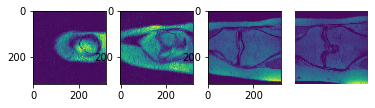

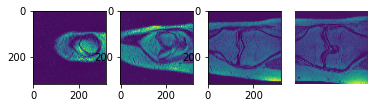

In [4]:
file_path = '/run/media/yxj996/CURZ/results/file1000817.h5'

with h5py.File(file_path,  "r") as hf:
    volume_kspace_4af = hf['recon_4af'][()]
    print(volume_kspace_4af.shape)
    volume_kspace_8af = hf['recon_8af'][()]
    print(volume_kspace_8af.shape)
    show_slices(volume_kspace_4af, [5, 10, 15, 20]) # Reconstructed slices 0, 5  10 15  with undersampling rate 4
    show_slices(volume_kspace_8af, [5, 10, 15, 20]) # Reconstructed slices 0, 5  10 15  with undersampling rate 8
    

## 4 Experiments

In the experient, we chose U-net model and fixed some variables: learning rate is 0.0001, channels are 64 and epochs are set as 30. And we ran the procedure by seting the acceleration as 8 and the center fraction is 0.04.Here are some comparison methods and results.

|Model|Channels|Pool layers|Loss|Optimizer|Test SSIM|Train SSIM|
|-----|--------|----|----|---------|------------|-------------|
|U-net|    32  |  3 |SSIM|  Adam   |    0.5917   |    0.5323    |
|U-net|    64  |  5 |SSIM|  Adam   |    0.5987   |    0.5985    |

                                      Table 1: Comparison the different channels and pools 
                         
Table 1 shows the various test results and train data by comparing two kind of channels and pools,which indicates that the result is better with 64 channels and 5 pool layers rather than 32 channels and 3 pool layers.

|Model|Channels|Pool layers|Loss|Optimizer|Test SSIM|Train SSIM|
|-----|--------|----|----|---------|------------|-------------|
|U-net|    64  |  5 |MSE|  Adam   |    0.5719   |   0.5331    |
|U-net|    64  |  5 |L1|  Adam   |    0.5765   |    0.5281    |

                                       Table 2: Comparison the different loss functions 

Table 2 illustrates the test and train results with MSE and L1 loss functions. It can be seen that SSIM loss function performs the best among these loss functions.

Therefore, SSIM loss function could also be fixed to compare other elements, such as optimizers.

|Model|Channels|Pool layers|Loss|Optimizer|Test SSIM|Train SSIM|
|-----|--------|-----------|----|---------|---------|----------|
|U-net|    64  |   5       |SSIM|  SGD   |  0.4502 |   0.3903 |

                                       Table 3: Comparison the different optimizers 

Table 3 demonstrates that SGD as the optimizer underperforms than the Adam as the optimizer. To summarize, the procedure performs well with SSIM loss functon, Adam as opitimizer, 64 channels and 5 poolayers depended on 8 acceleration and 0.04 center fraction in the U-net model.

After testing 8-fold acceleration and 0.04 central fraction, the next test is 4-fold acceleration and 0.08 central fraction. In this round of testing, we test the results of three different loss functions and two optimizer trained by the U-Net. Through variable control, we will first filter the loss function, then the optimizer, and finally select the best Channels and Acceleration.

|  Model | Channels |Pool Layers|Loss Function| Optimizer |  Test Loss  | Test SSIM|
|--------|---------|---------|---------|-----------------|--------|--------|
|  U-net |    64    | 5|  L1  |  ADAM  |  0.0346  |    0.6901   |
|  U-net |    64    | 5|  MSE  |  ADAM |  0.0027  | 0.6731     |
|  U-net |    64    |  5| SSIM  | ADAM |  0.6625 | 0.6907      |

Table 4: MRI image reconstruction performance on the same channel, optimizer but different Loss functions. L1, MSE and SSIM loss functions

Table 4 shows that we use different loss functions under the same Adam(optimizer) and 64 Channels, 5 Pool layers. Different loss functions show different results. By comparing the results, we find that SSIM has better performance as a loss function which performed.

Next, we will compare the results obtained under different optimizers using SSIM as the loss function and same number Channels and Acceleration:

|  Model | Channels |Pool Layers |Loss Function| Optimizer |  Test Loss  | Test SSIM|
|--------|---------|---------|---------|-----------------|--------|--------|
|  U-net |    64    |5| SSIM |  ADAM  |  0.6625  |    0.6907   |
|  U-net |    64   | 5| SSIM | SGD |  0.5516 | 0.5540    |

Table 5: MRI image reconstruction performance on the same number of channels, loss Functions but different optimizers

After the experimental results in Table 5, we find that Adam as an optimizer can get better results.

Finally, we compared 32 Channels, 3 Pool layers with 64 Channels, 5 Pool layers, using the SSIM loss function and Adam optimizer, and got the following results:

|  Model | Channels |Pool layers|Loss Function| Optimizer |  Test Loss  | Test SSIM|
|--------|--------- |---------|---------|-----------------|--------|--------|
|  U-net |    64   | 5 | SSIM |  ADAM  |  0.6925 |  0.6907     |
|  U-net |    32   | 3 | SSIM | ADAM |  0.6641 | 0.6914    |

Table 6, MRI image reconstruction performance on the different number of channels,but same loss Functions and  optimizers

Although in this test, the results of using 32channels and 3 pool layers are slightly better, but according to the structure of U-Net and the above data analysis, this group of data is not representative, so it can be considered that using 64channels and 5 pool layers give better results.


So in all comparison tests, the best model we can get is:

|  Model | Acceleration|Central Fraction|Channels |Pool layers|Loss Function| Optimizer |  Test Loss  | Test SSIM|
|--------|--------- |--------- |--------- |---------|---------|-----------------|--------|--------|
|  U-net | 32 | 3 |    64   | 5 | SSIM |  ADAM  |  0.6925 |  0.6907     |

                                            Table 7, the best model

## 5 Conclusions

This paper focuses on how to reconstruct images by using MRI (magnetic resonance imaging), which is relatively essential in the medical field. However, the current technology cannot guarantee the production of sharper images within a short time. Therefore, according to the requirements from the tutor and related materials, the group needs to find the fittest functions and parameters to complete this research.

The group has determined that the undersampled method and inverse Discrete Fourier Transform would be used before this experiment. Besides, SSIM (Structural Similarity Index Metrics) is going to be the measurement of the final result, which means that the closer it is to one, the higher the similarity. Thus, the model, loss functions, channels, optimizers, epochs, and the learning rate are considered as the most significant modules for reconstructing the image and comparing with the ground truth image. After a large number of analyses, the acceleration rate is set as 4 or 8, the learning rate is 0.0001 epochs are 30, and the model is U-Net. The value will stabilize when the period exceeds 15. However, there are two optimization algorithms: Adam and SGD (stochastic gradient descent), three loss-functions: L1, MSE (mean-square error, which is also can be called L2), and SSIM as well as two channels: channel 1 and channel 2 which are applicable for this trial.To find the most suitable parameters, the control variable method is adopted. Over repeated experiments and comparisons, the group found that channel 1, SSIM, and Adam are superior to other modules that have similar features, which generate a value of at the end. 

MRI is a very influential technique that can diagnose a lot of diseases. However, it is regrettable that if the doctor wants to produce the image which has enough high pixels may lead to expensive cost and plenty of time. What is worse is that it may account for the increase in the patient's stress to some extent. This means that MRI is still a technology that needs to be perfected. Nowadays there are a large amount of major medical institutions and enterprises have devoted themselves to researching it, which shows it is likely to be more exceptional shortly.

## 6 Description of Contribution

Haodong Zuo: Write the code, write Reconstruction part of the report.

Jing Bai: Run code, comparing the output of model and writing comments in the source code. Besides, I did most of report design. In this report, I write 3 sections: introduction, data loader and experimental results.

Shuqi Liu: Run Code, write the design part of Loss and introduction of implementation. Write comments in the source code(loss functions), co-build forms in the results.

Yifan Guo:Explaining the U-Net model in design section, run the code, write comments in U-Net model, co-build forms in the results.

Yunong Jiang: Run code, write comments of the data_loader. Write the optimizer and the conclusion in the report.


## 7 Reference

[1] No Author, fastMRI: Accelerating MR Imaging with AI, https://fastmri.org/ , 19 December 2019

[2] Zbontar, Jure, Knoll, Florian, Sriram, Anuroop. fastMRI: An Open Dataset and Benchmarks for Accelerated MRI[J], 19 December 2019.

[3] No author. Coursework 2019/2020. Available at: https://canvas.bham.ac.uk/courses/38479/files/folder/Coursework?preview=8255985, 19 December 2019

[4] ‘Fast as Adam & Good as SGD’ — New Optimizer Has Both (2019) Available at: https://medium.com/syncedreview/iclr-2019-fast-as-adam-good-as-sgd-new-optimizer-has-both-78e37e8f9a34, 6 December 2019.

[5] Ruder, S. (2016). An overview of gradient descent optimization algorithms. arXiv preprint arXiv:1609.04747.

[6] Kingma, D. P., & Ba, J. (2014). Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980.

[7] Adam — latest trends in deep learning optimization. (2018) Available at: https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c, 8 December 2019. 

[8] Ronneberger, O., Fischer, P. and Brox, T., 2015, October. U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

[9] Wu Zhenglong,Comparison L1 loss function with L2 loss function,https://medium.com/@ZhengLungWu/l1-loss%E5%92%8Cl2-loss%E6%AF%94%E8%BC%83-2f4b7dda12d, 15 December 2019

[10] No Author, Structural Similarity, https://en.wikipedia.org/wiki/Structural_similarity, 16 December 2019